# Taxi Trips (solution)

In [ ]:
%%bash
mkdir -p ~/.local/share/jupyter/kernels/ai4seismology-bigdata
cp /data/horse/ws/s4122485-ai4seismology_dev/thursday_bigdata/kernel.json ~/.local/share/jupyter/kernels/ai4seismology-bigdata

# Select ai4seismology-bigdata kernel

In [ ]:
import sys

In [ ]:
!{sys.executable} -m pip install --user --upgrade ipympl jupyter_leaflet leafmap ipyleaflet

# Restart the Jupyter Server

In [1]:
# To enable horizontal scrolling
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Initialisation of Spark cluster

In [2]:
# Note: Skip if running on local machine
# Import utilities required to run big data frameworks on ZIH HPC systems
from big_data_utils.environment_utils import ClusterConfig
from big_data_utils.cluster_utils import ClusterService
from big_data_utils.utils import kill_java_processes_by_name

In [3]:
# Note: Skip if running on local machine
# Configure the cluster environment
myconfig = ClusterConfig(fw_name="spark")
#myconfig.configure_env(conf_dest="./my-conf", conf_template="/projects/p_scads_bigdatahpc/.template/spark")
myconfig.configure_env(conf_dest="./my-conf",randomize_ports=True)

[INFO ] [08/05/2025 11:11:45] - Removing existing configuration directory: './my-conf'
[INFO ] [08/05/2025 11:11:45] - Environment configuration initialized:
[INFO ] [08/05/2025 11:11:45] -   • Framework:        SPARK
[INFO ] [08/05/2025 11:11:45] -   • Config template:  /software/rapids/r24.04/Spark/3.5.0-GCC-13.2.0-hadoop3/conf
[INFO ] [08/05/2025 11:11:45] -   • Config target:    ./my-conf
[INFO ] [08/05/2025 11:11:45] -   • Log directory:    ./my-conf/log
[INFO ] [08/05/2025 11:11:45] - Initializing configuration from template.
[INFO ] [08/05/2025 11:11:47] - Cluster topology:
[INFO ] [08/05/2025 11:11:47] -   • Master node:  n1498:7676
[INFO ] [08/05/2025 11:11:47] -   • Worker nodes: n1498
[INFO ] [08/05/2025 11:11:48] -   • Spark master URL: spark://n1498:7676
[INFO ] [08/05/2025 11:11:48] - Once the cluster is started, one can access the spark GUI in browser using port forwarding.
[INFO ] [08/05/2025 11:11:48] - To access, spark GUI, type following in your terminal on local mac

In [4]:
# Initialize the cluster service class
mycluster = ClusterService("spark")

# Check which processes are running
mycluster.check_status()

[INFO ] [08/05/2025 11:11:49] - Currently, following java processes are running:
[INFO ] [08/05/2025 11:11:50] - 	Process ID, Name 


In [5]:
# Note: Skip if running on local machine
# Start Spark standalone cluster
mycluster.start_cluster()

[INFO ] [08/05/2025 11:11:51] - Starting SPARK cluster.
[INFO ] [08/05/2025 11:11:57] - Logging cluster startup info at: ./my-conf/spark/log/cluster.log

----Performance Data----
Duration: 5.53

CPU Util (Across CPUs)       	AVG: 17.06	 MIN: 0.00	 MAX: 100.00
Mem Util in GB (Across nodes)	AVG: 218.53	 MIN: 218.43	 MAX: 218.63
IO Ops (excl.) Read          	Total: 30261
               Write         	Total: 3776
IO Bytes (excl.) Read        	Total: 55.62
                 Write       	Total: 0.61


In [6]:
# Note: Skip if running on local machine
# Check if the master and worker processes are started or not
mycluster.check_status()

[INFO ] [08/05/2025 11:11:58] - Currently, following java processes are running:
[INFO ] [08/05/2025 11:11:58] - 	Process ID, Name 
[INFO ] [08/05/2025 11:11:58] - 	387396, Master
[INFO ] [08/05/2025 11:11:58] - 	387464, Worker


# Download of NYC taxi trips and taxi zone file
Modify the base directory in the following cell if you want to save data files in different directories.

In [7]:
base_directory = "./data"

In [8]:
import os
import wget
import zipfile

base_directory = os.path.abspath(base_directory)
os.environ["BASEDIRECTORY"] = base_directory

# Download yellow trip data
data_directory = base_directory + "/taxidata"
data_file = "yellow_tripdata_2022-01.parquet"
data_path = data_directory + "/" + data_file
if not os.path.exists(data_path):
    os.makedirs(data_directory, exist_ok=True)
if not os.path.exists(data_path):
    wget.download("https://d37ci6vzurychx.cloudfront.net/trip-data/" + data_file, out = data_directory)   

# Download zone data
zone_directory = base_directory + "/taxizonesdata"
if not os.path.isdir(zone_directory):
    os.makedirs(zone_directory, exist_ok=True)

zone_zipfile = "taxi_zones.zip"
zone_zipfile_path = zone_directory + "/" + zone_zipfile
if not os.path.exists(zone_zipfile_path):
    wget.download("https://d37ci6vzurychx.cloudfront.net/misc/" + zone_zipfile, out = zone_directory)
    with zipfile.ZipFile(zone_zipfile_path, "r") as zip_ref:
        zip_ref.extractall(zone_directory)
        zip_ref.close()
    
zone_lookup_file = "taxi_zone_lookup.csv"
if not os.path.exists(zone_directory + "/" + zone_lookup_file):
    wget.download("https://d37ci6vzurychx.cloudfront.net/misc/" + zone_lookup_file, out = zone_directory)

# Initialisation of Spark context

In [9]:
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])
print(os.environ['SPARK_HOME'])

/software/rapids/r24.04/Spark/3.5.0-GCC-13.2.0-hadoop3


In [10]:
import platform
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master(f"spark://{myconfig.get_master_host()}:{myconfig.get_master_port()}") \
    .appName("Python Spark Map Visualization of NYC taxi trips") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/08 11:12:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



----Performance Data----
Duration: 6.21

CPU Util (Across CPUs)       	AVG: 16.10	 MIN: 0.00	 MAX: 66.20
Mem Util in GB (Across nodes)	AVG: 219.03	 MIN: 218.94	 MAX: 219.14
IO Ops (excl.) Read          	Total: 32456
               Write         	Total: 3940
IO Bytes (excl.) Read        	Total: 86.50
                 Write       	Total: 0.77


In [11]:
# Check running java processes
mycluster.check_status()

[INFO ] [08/05/2025 11:12:09] - Currently, following java processes are running:
[INFO ] [08/05/2025 11:12:10] - 	Process ID, Name 
[INFO ] [08/05/2025 11:12:10] - 	387621, SparkSubmit
[INFO ] [08/05/2025 11:12:10] - 	387396, Master
[INFO ] [08/05/2025 11:12:10] - 	387725, CoarseGrainedExecutorBackend
[INFO ] [08/05/2025 11:12:10] - 	387464, Worker


In [12]:
trips = spark.read.parquet(base_directory + "/taxidata/yellow_tripdata_2022-01.parquet")


----Performance Data----
Duration: 5.29

CPU Util (Across CPUs)       	AVG: 18.45	 MIN: 0.00	 MAX: 52.80
Mem Util in GB (Across nodes)	AVG: 220.96	 MIN: 219.65	 MAX: 221.68
IO Ops (excl.) Read          	Total: 34439
               Write         	Total: 4027
IO Bytes (excl.) Read        	Total: 86.53
                 Write       	Total: 0.83


In [13]:
trips.dtypes

[('VendorID', 'bigint'),
 ('tpep_pickup_datetime', 'timestamp_ntz'),
 ('tpep_dropoff_datetime', 'timestamp_ntz'),
 ('passenger_count', 'double'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'double'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'bigint'),
 ('DOLocationID', 'bigint'),
 ('payment_type', 'bigint'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'double'),
 ('airport_fee', 'double')]

In [14]:
trips.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2022-01-01 00:35:40|  2022-01-01 00:53:29|            2.0|          3.8|       1.0|                 N|         142|         236|           1|       14.5|  3.0|    0.5|      3.6

# Grouping using groupBy

In [15]:
# using groupBy
trips.groupBy("VendorID").count().show()

+--------+-------+
|VendorID|  count|
+--------+-------+
|       6|   5563|
|       5|     36|
|       1| 742273|
|       2|1716059|
+--------+-------+



# Exercise 1
Count trips grouped by passengers.

Are there unexpected values? How can they be interpreted? Find more information on https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.

In [16]:
trips.groupBy("passenger_count").count().show() #add something here

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|            8.0|      8|
|            0.0|  52061|
|            7.0|      9|
|           NULL|  71503|
|            1.0|1794055|
|            4.0|  35321|
|            3.0|  84570|
|            2.0| 343026|
|            6.0|  32037|
|            5.0|  51338|
|            9.0|      3|
+---------------+-------+



# Exercise 2
Find the minimal distance for these groups. Are there unexpected values? How can they be interpreted?

In [17]:
trips.groupBy("passenger_count").min("trip_distance").show() #add something here

+---------------+------------------+
|passenger_count|min(trip_distance)|
+---------------+------------------+
|            8.0|               0.0|
|            0.0|               0.0|
|            7.0|               0.0|
|           NULL|               0.0|
|            1.0|               0.0|
|            4.0|               0.0|
|            3.0|               0.0|
|            2.0|               0.0|
|            6.0|               0.0|
|            5.0|               0.0|
|            9.0|               0.0|
+---------------+------------------+



# Exercise 3
Remove all trip distances of 0.0 miles from the previous result. What do you expect?

In [18]:
trips.filter(trips.trip_distance > 0.0).groupby("passenger_count").min("trip_distance").show() #add something here

+---------------+------------------+
|passenger_count|min(trip_distance)|
+---------------+------------------+
|            8.0|              4.09|
|            0.0|              0.01|
|            7.0|              0.32|
|           NULL|              0.01|
|            1.0|              0.01|
|            4.0|              0.01|
|            3.0|              0.01|
|            2.0|              0.01|
|            6.0|              0.01|
|            5.0|              0.01|
|            9.0|              0.12|
+---------------+------------------+



# SQL Queries

In [19]:
from pyspark.sql.types import *

sqlContext = SparkSession.builder.getOrCreate()

In [20]:
# Create a temporary view from the DataFrame
trips.createOrReplaceTempView("trips")

In [21]:
# Apply a SQL query
query = "SELECT fare_amount FROM trips WHERE trip_distance>=5"
sqlContext.sql(query).show()

+-----------+
|fare_amount|
+-----------+
|       33.0|
|       17.0|
|       20.0|
|       34.5|
|       21.0|
|       16.0|
|       18.5|
|       52.0|
|       52.0|
|       19.5|
|       23.5|
|       52.0|
|       52.0|
|       24.5|
|       21.5|
|       52.0|
|       19.0|
|       33.0|
|       45.5|
|       20.5|
+-----------+
only showing top 20 rows



# Exercise 4
Rewrite the previous statement without SQL, but with a functional statement.

In [22]:
trips.filter(trips.trip_distance > 5).select("fare_amount").show() # add something here

+-----------+
|fare_amount|
+-----------+
|       33.0|
|       17.0|
|       20.0|
|       34.5|
|       21.0|
|       16.0|
|       18.5|
|       52.0|
|       52.0|
|       19.5|
|       23.5|
|       52.0|
|       52.0|
|       24.5|
|       21.5|
|       52.0|
|       19.0|
|       33.0|
|       45.5|
|       20.5|
+-----------+
only showing top 20 rows



In [23]:
#compute summary statistics
trips.describe().show()

25/05/08 11:12:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+-----------------+--------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|     total_amount|congestion_surcharge|        airport_fee|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+-----------------+--------------------+-------

# Exercise 5
Find the distance for tips larger than $5  - Formulate a SQL query and apply it on the DataFrame.

In [24]:
query =  "SELECT trip_distance FROM trips WHERE fare_amount>5"# add something here
sqlContext.sql(query).show()

+-------------+
|trip_distance|
+-------------+
|          3.8|
|          2.1|
|         0.97|
|         1.09|
|          4.3|
|         10.3|
|         5.07|
|         2.02|
|         2.71|
|         1.91|
|         2.16|
|         1.43|
|         1.58|
|          4.2|
|          2.2|
|          3.9|
|          3.2|
|          1.2|
|          1.7|
|          1.6|
+-------------+
only showing top 20 rows



# Exercise 6
Formulate a query to get sum of total amount of trip for distances larger than 30 miles.

In [25]:
query = "SELECT SUM(total_amount) FROM trips WHERE trip_distance>30" # add something here
sqlContext.sql(query).show()

+------------------+
| sum(total_amount)|
+------------------+
|273382.60999999923|
+------------------+



# Exercise 7
Create a box-and-whisker plot of the numerical columns. What do these say about the data?

In [26]:
%matplotlib inline

In [27]:
import matplotlib.pyplot as plt

VendorID quantiles: [1.0, 1.0, 2.0, 2.0, 6.0]


passenger_count quantiles: [0.0, 1.0, 1.0, 1.0, 9.0]


trip_distance quantiles: [0.0, 1.06, 1.74, 3.16, 306159.28]


RatecodeID quantiles: [1.0, 1.0, 1.0, 1.0, 99.0]


PULocationID quantiles: [1.0, 132.0, 162.0, 236.0, 265.0]


DOLocationID quantiles: [1.0, 113.0, 162.0, 236.0, 265.0]


payment_type quantiles: [0.0, 1.0, 1.0, 1.0, 5.0]


fare_amount quantiles: [-480.0, 6.5, 9.0, 14.0, 401092.32]


extra quantiles: [-4.5, 0.0, 0.5, 2.5, 33.5]
mta_tax quantiles: [-0.5, 0.5, 0.5, 0.5, 16.59]


tip_amount quantiles: [-125.22, 0.08, 2.0, 3.0, 888.88]
tolls_amount quantiles: [-31.4, 0.0, 0.0, 0.0, 193.3]
improvement_surcharge quantiles: [-0.3, 0.3, 0.3, 0.3, 0.3]


total_amount quantiles: [-480.3, 11.3, 14.55, 20.16, 401095.62]


congestion_surcharge quantiles: [-2.5, 2.5, 2.5, 2.5, 2.5]
airport_fee quantiles: [-1.25, 0.0, 0.0, 0.0, 1.25]


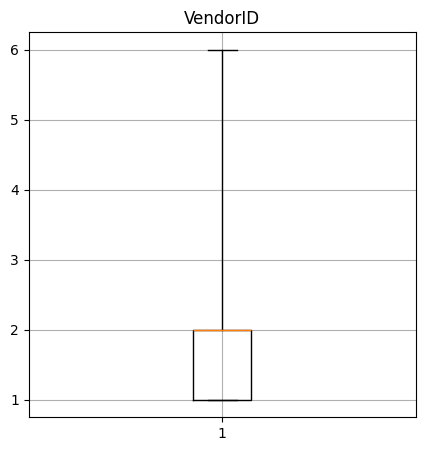

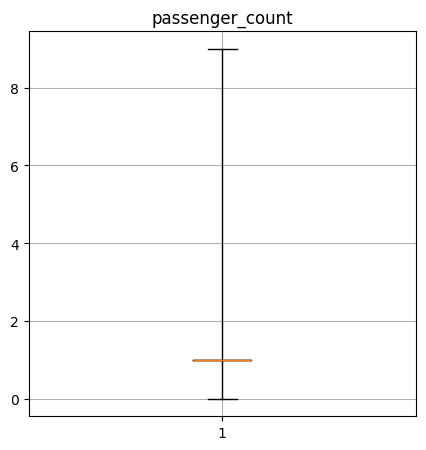

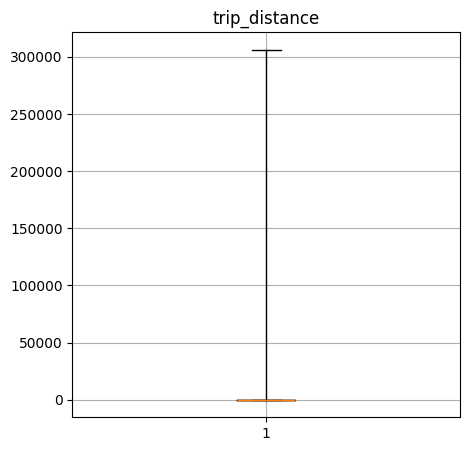

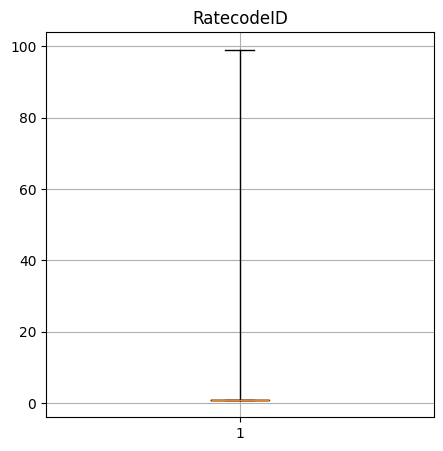

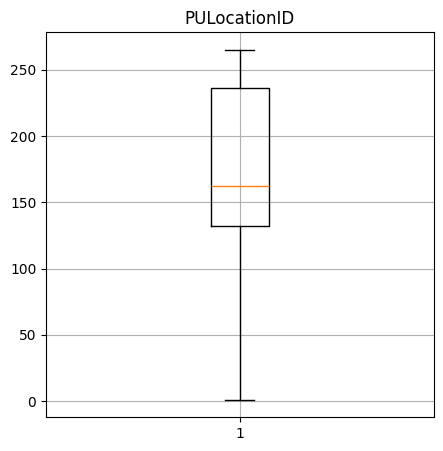

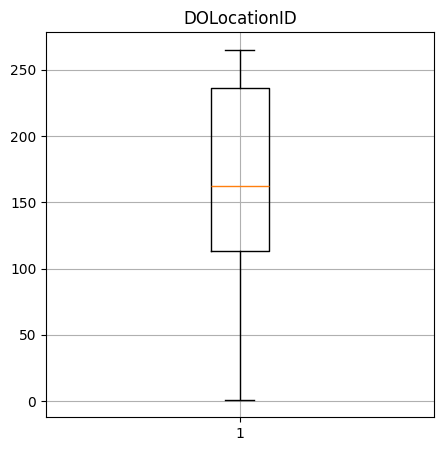

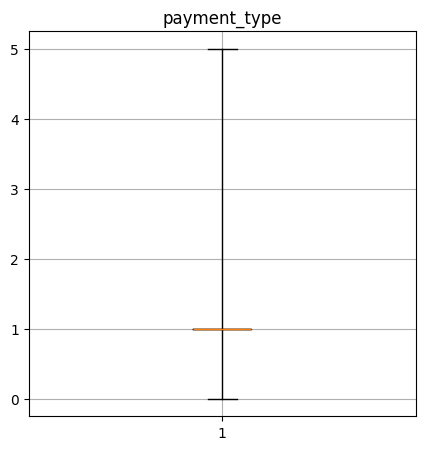

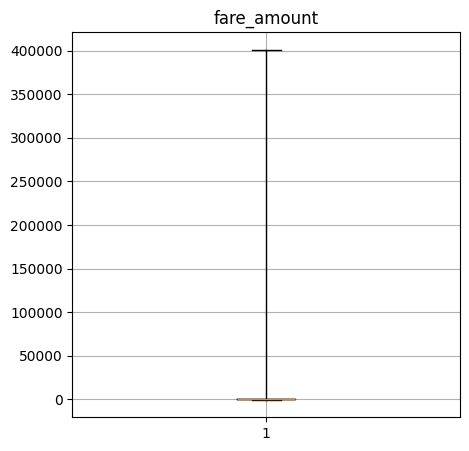

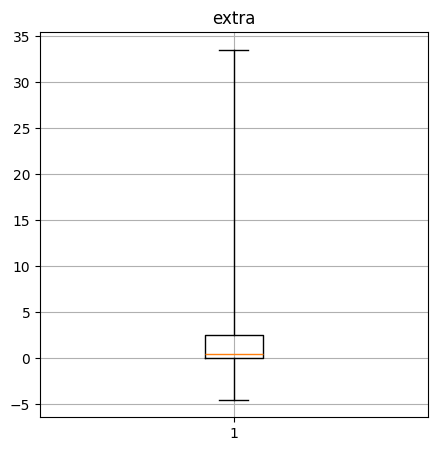

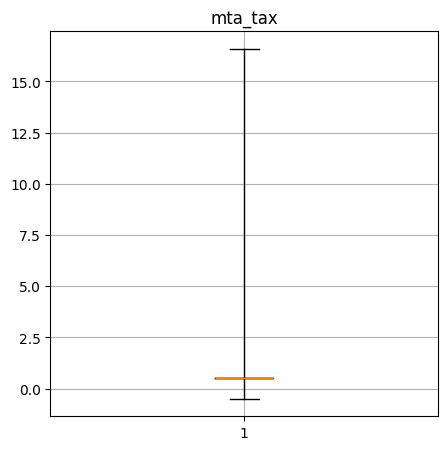

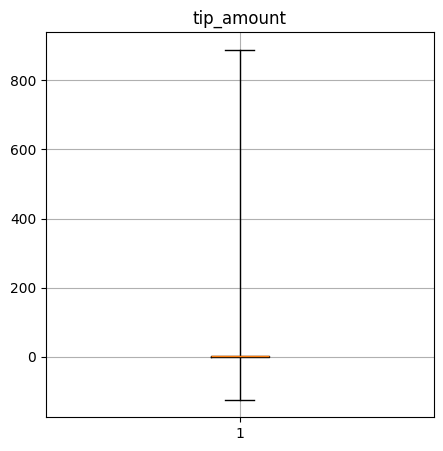

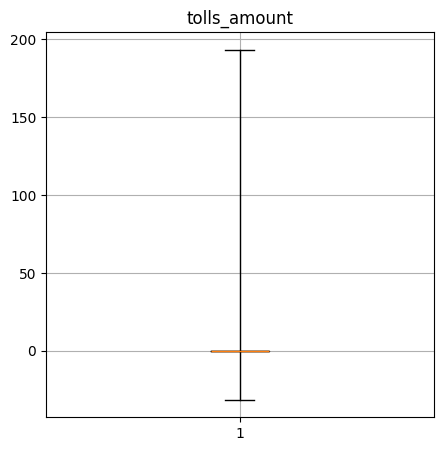

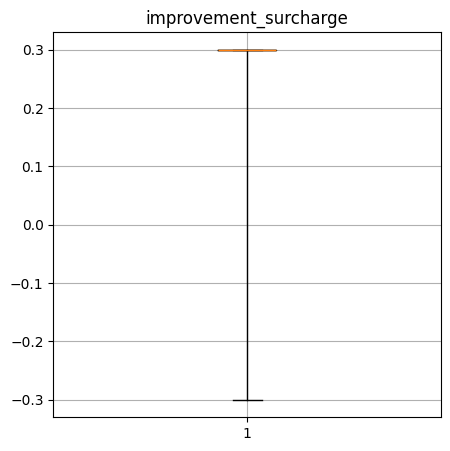

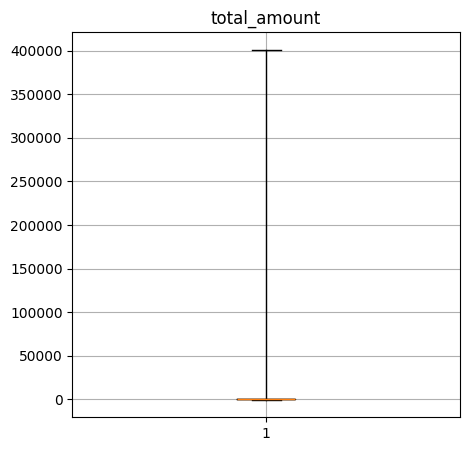

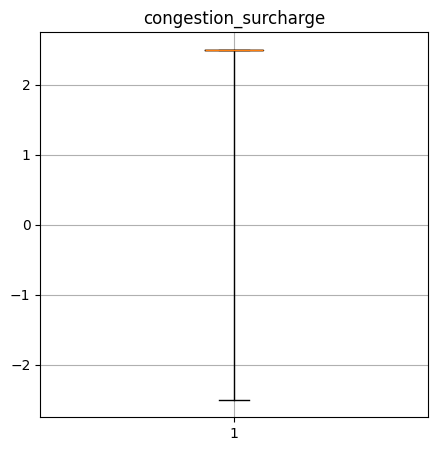

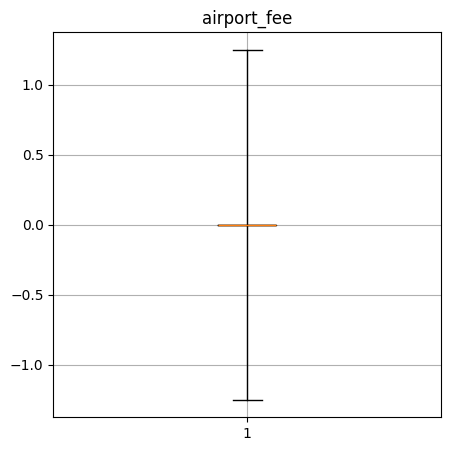


----Performance Data----
Duration: 15.90

CPU Util (Across CPUs)       	AVG: 30.01	 MIN: 4.00	 MAX: 100.00
Mem Util in GB (Across nodes)	AVG: 221.15	 MIN: 220.59	 MAX: 222.70
IO Ops (excl.) Read          	Total: 37208
               Write         	Total: 4655
IO Bytes (excl.) Read        	Total: 86.78
                 Write       	Total: 1.35


In [28]:
for column in trips.dtypes:
    name = column[0]
    colType = column[1]
    if colType != 'string' and colType != 'timestamp' and colType != 'timestamp_ntz':
        columnQuantiles = trips.approxQuantile(col=name,probabilities=[0.0,0.25,0.50,0.75,1.00],relativeError=0.01) # add something here
        print("{} quantiles: {}".format(name,columnQuantiles))
        stats = [{
            "whislo": columnQuantiles[0], # add something here
            "q1": columnQuantiles[1], # add something here
            "med": columnQuantiles[2], # add something here
            "q3": columnQuantiles[3], # add something here
            "whishi": columnQuantiles[4], # add something here
        }]
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharey=True)
        axes.bxp(bxpstats=stats, showfliers=False)
        axes.grid(True)
        axes.set_title(name)

# Exercise 8
Provide an overview over the number of trips per week day.

In [29]:
def barchart(dataRows, titleSuffix):
    positions = list(reversed(range(len(dataRows))))
    names = [str(item[titleSuffix]) + " (" + str(item['count']) + ")" for item in dataRows]
    values = [item['count'] for item in dataRows]
    plt.grid()
    plt.barh(positions,values,align="center")
    plt.yticks(positions,names)
    plt.xlabel("Number of trips")
    plt.title("Distribution of trips per " + titleSuffix)
    plt.show()

In [30]:
import datetime
help(datetime.datetime.weekday)

Help on method_descriptor:

weekday(...)
    Return the day of the week represented by the date.
    Monday == 0 ... Sunday == 6



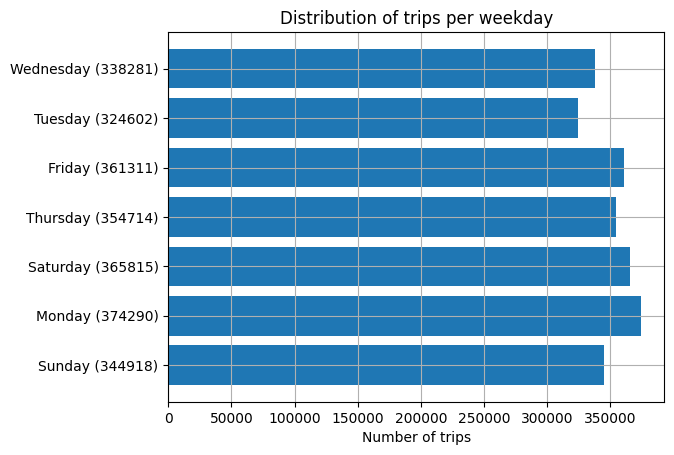


----Performance Data----
Duration: 21.06

CPU Util (Across CPUs)       	AVG: 16.00	 MIN: 0.00	 MAX: 100.00
Mem Util in GB (Across nodes)	AVG: 221.70	 MIN: 220.72	 MAX: 223.88
IO Ops (excl.) Read          	Total: 39851
               Write         	Total: 4822
IO Bytes (excl.) Read        	Total: 91.58
                 Write       	Total: 1.45


In [31]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
import calendar

#udf stands for user defined function
@udf 
def weekdayStr(d):
    return calendar.day_name[d.weekday()] # add something here

@udf(returnType=IntegerType())
def weekday(d):
    return d.weekday()

#Replace function weekday with function weekdayStr if you want.
weekdayRows = trips.select(weekdayStr(trips.tpep_dropoff_datetime).alias("weekday")).groupby("weekday").count().collect() # add something here

barchart(weekdayRows, "weekday")

# Exercise 9
Provide an overview over the number of trips per hour.

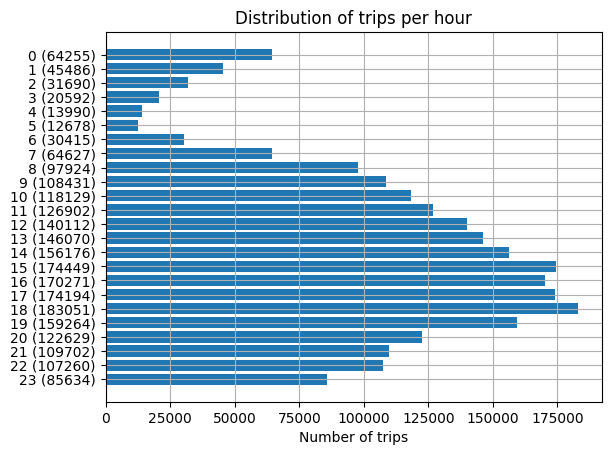


----Performance Data----
Duration: 11.59

CPU Util (Across CPUs)       	AVG: 25.43	 MIN: 0.00	 MAX: 100.00
Mem Util in GB (Across nodes)	AVG: 221.26	 MIN: 221.07	 MAX: 221.98
IO Ops (excl.) Read          	Total: 46157
               Write         	Total: 4923
IO Bytes (excl.) Read        	Total: 91.60
                 Write       	Total: 1.49


In [32]:
@udf(returnType=IntegerType())
def hour(d):
    return d.hour

hourRows = sorted(trips.select(hour(trips.tpep_dropoff_datetime).alias("hour")).groupby("hour").count().collect())# add something here

barchart(hourRows, "hour")

# Map Visualisations

In [33]:
import leafmap

In [34]:
def getMap():
    map_args={
        "google_map":"HYBRID",
        #center to New York at 41 degrees north and 74 degrees west ([lat, lon])
        "center":[40.702557, -74.012318],
        "zoom":12,
        "height":"450px",
        "width":"800px",
        "max_zoom":"20"
    }
    return leafmap.Map(**map_args)

In [35]:
getMap()

Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [36]:
def taxizoneColorFunction(taxiZonesIntensity, maximum_intensity, taxizoneFeature):
    taxizoneId = taxizoneFeature["properties"]["LocationID"]
    taxizoneIntensity = taxiZonesIntensity[taxizoneId] if taxizoneId in taxiZonesIntensity else 0
    return {
        "color": "black",
        "fillColor": '#%02X0000' % (int(taxizoneIntensity*255/maximum_intensity))
    }
def getTaxiZoneStylingFunction(taxiZonesIntensity):
    maximum_intensity = max(taxiZonesIntensity.values())
    return lambda x: taxizoneColorFunction(taxiZonesIntensity, maximum_intensity, x)

In [37]:
taxizonesFile = base_directory+"/taxizonesdata/taxi_zones.shp" ############# has only zones till 263

def getZoneCenters():
    zone_centers={}
    my_geojson = leafmap.shp_to_geojson(taxizonesFile)
    
    for feature in my_geojson["features"]:
        location = feature["properties"]["LocationID"]
        coordinates = feature["geometry"]["coordinates"]
        
        avg_lat = 0
        avg_lon = 0
        count = 0
        for coordinate_list in coordinates:
            for coordinate in coordinate_list:
                if type(coordinate) == tuple and len(coordinate) == 2: #############
                    avg_lat += coordinate[1]
                    avg_lon += coordinate[0]
                    count += 1
                elif len(coordinate) > 2: 
                    for coord in coordinate:
                        avg_lat += coord[1]
                        avg_lon += coord[0]
                        count += 1
                elif len(coordinate) < 2: #############
                    print(coordinate)
        avg_lat = avg_lat/count
        avg_lon = avg_lon/count
        zone_centers[location]=[avg_lat, avg_lon]
    return zone_centers

zoneCenters = getZoneCenters()

In [38]:
def getHeatCenters(taxizoneIntensityMap):
    heat_data=[]
    for key, value in zoneCenters.items():
        location = key
        (lat, lon) = value
        taxizoneIntensity = taxizoneIntensityMap[location] if location in taxizoneIntensityMap else 0
        heat_data.append([lat, lon, taxizoneIntensity])
    return heat_data

# Exercise 10
Get the number of trips which start/end in each zone.

In [39]:
pickupData = trips.groupBy("PULocationID").count().sort("PULocationID").collect() #add something here
dropoffData = trips.groupBy("DOLocationID").count().sort("DOLocationID").collect() #add something here
grouped_by_pickup_location={row["PULocationID"]:row["count"] for row in pickupData}
grouped_by_dropoff_location={row["DOLocationID"]:row["count"] for row in dropoffData}

In [40]:
m = getMap()
m.add_shp(in_shp=taxizonesFile,layer_name="taxizone",style={},hover_style={}, style_callback=getTaxiZoneStylingFunction(grouped_by_pickup_location), fill_colors=None,
              info_mode='on_hover')
m.layer_opacity('taxizone', 0.9)
m.add_heatmap(data=getHeatCenters(grouped_by_pickup_location), name='pickup_heat', radius=10)
m.layer_opacity('pickup_heat', 0.9)
m

Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [41]:
m = getMap()
m.add_shp(in_shp=taxizonesFile,layer_name="taxizone",style={},hover_style={}, style_callback=getTaxiZoneStylingFunction(grouped_by_dropoff_location), fill_colors=None,
              info_mode='on_hover')
m.layer_opacity('taxizone', 0.9)
m.add_heatmap(data=getHeatCenters(grouped_by_dropoff_location), name='dropoff_heat', radius=10)
m.layer_opacity('dropoff_heat', 0.9)
m

Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

# Exercise 11
Collect the trips with the 10 highest tips. Be careful not to use trips with zones which indicate "Unknown" or N/Avalues.

In [42]:
import pyspark.sql.functions as F

In [43]:
zoneLookup = spark.read.csv(base_directory + "/taxizonesdata/taxi_zone_lookup.csv", header=True, inferSchema=True)

In [44]:
zoneLookup.filter(zoneLookup.Borough == "Unknown").show()
zoneLookup.filter(zoneLookup.Borough == "N/A").show()

+----------+-------+----+------------+
|LocationID|Borough|Zone|service_zone|
+----------+-------+----+------------+
|       264|Unknown| N/A|         N/A|
+----------+-------+----+------------+

+----------+-------+--------------+------------+
|LocationID|Borough|          Zone|service_zone|
+----------+-------+--------------+------------+
|       265|    N/A|Outside of NYC|         N/A|
+----------+-------+--------------+------------+



In [45]:
zoneLookup.dtypes

[('LocationID', 'int'),
 ('Borough', 'string'),
 ('Zone', 'string'),
 ('service_zone', 'string')]

In [46]:
trips.dtypes

[('VendorID', 'bigint'),
 ('tpep_pickup_datetime', 'timestamp_ntz'),
 ('tpep_dropoff_datetime', 'timestamp_ntz'),
 ('passenger_count', 'double'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'double'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'bigint'),
 ('DOLocationID', 'bigint'),
 ('payment_type', 'bigint'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'double'),
 ('airport_fee', 'double')]

In [47]:
help(trips.join)

Help on method join in module pyspark.sql.dataframe:

join(other: 'DataFrame', on: Union[str, List[str], pyspark.sql.column.Column, List[pyspark.sql.column.Column], NoneType] = None, how: Optional[str] = None) -> 'DataFrame' method of pyspark.sql.dataframe.DataFrame instance
    Joins with another :class:`DataFrame`, using the given join expression.
    
    .. versionadded:: 1.3.0
    
    .. versionchanged:: 3.4.0
        Supports Spark Connect.
    
    Parameters
    ----------
    other : :class:`DataFrame`
        Right side of the join
    on : str, list or :class:`Column`, optional
        a string for the join column name, a list of column names,
        a join expression (Column), or a list of Columns.
        If `on` is a string or a list of strings indicating the name of the join column(s),
        the column(s) must exist on both sides, and this performs an equi-join.
    how : str, optional
        default ``inner``. Must be one of: ``inner``, ``cross``, ``outer``,
      

In [48]:
temporary = trips \
                .join(zoneLookup, trips.PULocationID == zoneLookup.LocationID) \
                .filter(zoneLookup.Borough != "Unknown") \
                .filter(zoneLookup.Borough != "N/A") \
                .filter(zoneLookup.Zone != "N/A") \
                .filter(zoneLookup.service_zone != "N/A") \
                .select(trips.columns)

temporary = temporary \
                .alias("temporary") \
                .join(zoneLookup.alias("zoneLookup"),F.col("temporary.DOLocationID") == F.col("zoneLookup.LocationID")) \
                .filter(F.col("zoneLookup.Borough") != "Unknown") \
                .filter(F.col("zoneLookup.Borough") != "N/A") \
                .filter(F.col("zoneLookup.Zone") != "N/A") \
                .filter(F.col("zoneLookup.service_zone") != "N/A") \
                .select(F.col("temporary.*"))

In [49]:
# add something here to filter out Unknown values
tripsWithHighestTips = temporary.orderBy(trips.tip_amount, ascending=False).limit(10).collect() # add something here to take the top 10 elements
tripsWithHighestTips

[Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2022, 1, 29, 2, 23, 46), tpep_dropoff_datetime=datetime.datetime(2022, 1, 29, 2, 32, 6), passenger_count=1.0, trip_distance=1.32, RatecodeID=1.0, store_and_fwd_flag='N', PULocationID=79, DOLocationID=249, payment_type=1, fare_amount=7.0, extra=0.5, mta_tax=0.5, tip_amount=888.88, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=899.68, congestion_surcharge=2.5, airport_fee=0.0),
 Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2022, 1, 15, 2, 27, 19), tpep_dropoff_datetime=datetime.datetime(2022, 1, 15, 2, 33, 34), passenger_count=5.0, trip_distance=1.3, RatecodeID=1.0, store_and_fwd_flag='N', PULocationID=79, DOLocationID=232, payment_type=1, fare_amount=6.5, extra=0.5, mta_tax=0.5, tip_amount=303.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=313.3, congestion_surcharge=2.5, airport_fee=0.0),
 Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2022, 1, 23, 7, 35, 29), tpep_dropoff_datetime=datet

In [50]:
from geojson import FeatureCollection, Feature, LineString
def to_lon_and_lat(latLonCoordinate):
    return [latLonCoordinate[1],latLonCoordinate[0]]

def trip_to_geojson(trip):
    start_point = to_lon_and_lat(zoneCenters[trip["PULocationID"]])
    end_point = to_lon_and_lat(zoneCenters[trip["DOLocationID"]])    
    props = {
        "starttime":trip["tpep_pickup_datetime"].isoformat(),
        "startzone":trip["PULocationID"],
        "endtime":trip["tpep_dropoff_datetime"].isoformat(),
        "endzone":trip["DOLocationID"],
    }
    return Feature(geometry=LineString([start_point, end_point]), properties=props)
    
def tripList_to_geojson(tripList):
    coll = FeatureCollection(list(map(lambda item: trip_to_geojson(item),tripList)))
    return coll

In [51]:
trip_geojson = tripList_to_geojson(tripsWithHighestTips)

In [52]:
for i in trip_geojson['features']:
    print(i)

print(trip_geojson['type'])

{"geometry": {"coordinates": [[-73.986487, 40.726759], [-74.003081, 40.733811]], "type": "LineString"}, "properties": {"endtime": "2022-01-29T02:32:06", "endzone": 249, "starttime": "2022-01-29T02:23:46", "startzone": 79}, "type": "Feature"}
{"geometry": {"coordinates": [[-73.986487, 40.726759], [-73.982954, 40.713594]], "type": "LineString"}, "properties": {"endtime": "2022-01-15T02:33:34", "endzone": 232, "starttime": "2022-01-15T02:27:19", "startzone": 79}, "type": "Feature"}
{"geometry": {"coordinates": [[-73.783745, 40.639068], [-73.783745, 40.639068]], "type": "LineString"}, "properties": {"endtime": "2022-01-23T08:10:12", "endzone": 132, "starttime": "2022-01-23T07:35:29", "startzone": 132}, "type": "Feature"}
{"geometry": {"coordinates": [[-73.865871, 40.763273], [-74.013983, 40.707456]], "type": "LineString"}, "properties": {"endtime": "2022-01-27T14:25:11", "endzone": 261, "starttime": "2022-01-27T13:57:38", "startzone": 70}, "type": "Feature"}
{"geometry": {"coordinates": [[

In [53]:
m = getMap()
m.add_shp(in_shp=taxizonesFile,layer_name="taxizone")
m.layer_opacity('taxizone', 0.9)
m.add_geojson(in_geojson=trip_geojson,layer_name="connections", style={"color":"red", "width":"4pt"})
m.layer_opacity('connections', 1.0)
m

Map(center=[40.702557, -74.012318], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [54]:
# Check status of runnning java processes
mycluster.check_status()

[INFO ] [08/05/2025 11:14:30] - Currently, following java processes are running:
[INFO ] [08/05/2025 11:14:30] - 	Process ID, Name 
[INFO ] [08/05/2025 11:14:30] - 	387621, SparkSubmit
[INFO ] [08/05/2025 11:14:30] - 	387396, Master
[INFO ] [08/05/2025 11:14:30] - 	387725, CoarseGrainedExecutorBackend
[INFO ] [08/05/2025 11:14:30] - 	387464, Worker


In [55]:
# Stopping spark context
sc.stop()
mycluster.check_status()

[INFO ] [08/05/2025 11:14:31] - Currently, following java processes are running:
[INFO ] [08/05/2025 11:14:32] - 	Process ID, Name 
[INFO ] [08/05/2025 11:14:32] - 	387621, SparkSubmit
[INFO ] [08/05/2025 11:14:32] - 	387396, Master
[INFO ] [08/05/2025 11:14:32] - 	387464, Worker


In [56]:
mycluster.stop_cluster()
kill_java_processes_by_name("SparkSubmit")

[INFO ] [08/05/2025 11:14:33] - Stopping SPARK cluster.
[INFO ] [08/05/2025 11:14:36] - Logging cluster stopping info at: ./my-conf/spark/log/cluster.log
Killing process SparkSubmit with PID 387621

----Performance Data----
Duration: 4.49

CPU Util (Across CPUs)       	AVG: 8.71	 MIN: 0.00	 MAX: 50.00
Mem Util in GB (Across nodes)	AVG: 220.47	 MIN: 220.20	 MAX: 220.82
IO Ops (excl.) Read          	Total: 82609
               Write         	Total: 6977
IO Bytes (excl.) Read        	Total: 217.33
                 Write       	Total: 2.26


In [57]:
mycluster.check_status()

[INFO ] [08/05/2025 11:14:38] - Currently, following java processes are running:
[INFO ] [08/05/2025 11:14:39] - 	Process ID, Name 
